# Apply Encoder of Transformer Model (Self Attention) to Explore RNA-Protein Binding

In [1]:
import pandas as pd
import tensorflow as tf
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline, make_pipeline
import datetime

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

2023-11-16 00:24:19.256528: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 00:24:19.282408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 00:24:19.578433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ly534/anaconda3/envs/tensorflow_base/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mo

## Data preparation

In [2]:
df_preprocess = pd.read_excel('data/source data.xlsx')

# df_preprocess.columns = ['promoter', 'fluorescence']
# df_preprocess.head()
# df  = df_preprocess


In [3]:
# 提取df_preprocess中的Promoter和均值给df
df = df_preprocess[['Promoter_x', '均值']]
df.head()
#df的s*列改为fluorescence
df.columns = ['promoter','fluorescence']

df.head(),df.shape

(                        promoter  fluorescence
 0  AAAACAGGCGCCTCGAGTCCTTGTATAAT      0.509753
 1  AAAACAGTGTGGGCCAATTGCTTTATAAT      0.658325
 2  AAAGTGATATTCTACATCACTCCTATAAT      1.023804
 3  AACGCAATAAGCTGTAGAAAGTGTATACT     10.809848
 4  AAGACAAAACATTAAGATAGACCTATAAT      1.738095,
 (112955, 2))

## Set hyper parameters

In [4]:
seq_length = 29
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
batch_size = 1024

## Functions to handle the RNA Inputs

In [5]:
def cutWord(x, window=1, length = seq_length):
    seq2word = []
    for i in range(length):
        seq2word.append(x[i*window:i*window+window])
    return " ".join(seq2word)

def RKA_bin(x):
    if x >= 0.8:
        return(1)
    else:
        return(0)

def MFE_bin(x):
    if x >= -14.:
        return(1)
    else:
        return(0)

## Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(df[["fluorescence"]]))

df["fluorescence_norm"] = scaler.transform(df[["fluorescence"]])

df[["fluorescence_logplus1"]] = df[["fluorescence"]].apply(lambda x: np.log(1+x))

MinMaxScaler()


<Axes: ylabel='Count'>

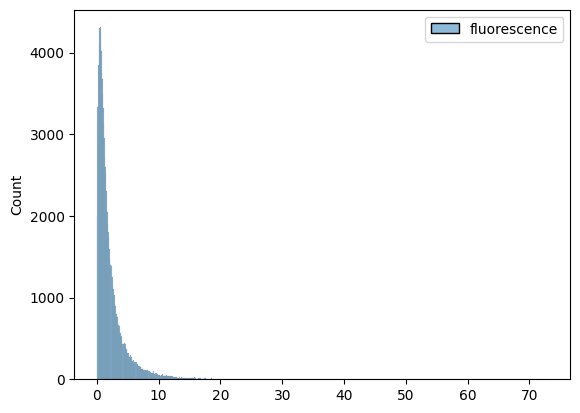

In [7]:
sns.histplot(df[["fluorescence"]])

<Axes: ylabel='Count'>

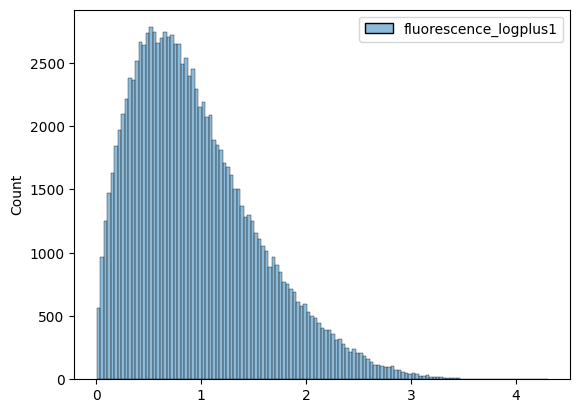

In [8]:
sns.histplot(df[["fluorescence_logplus1"]])

## Create dataset for Tensorflow model

In [9]:
# df["RKA_level"] = df.RKA.apply(RKA_bin)
# df["MFE_level"] = df.RKA.apply(MFE_bin)
# target = df[["MFE_level","RKA_level"]].copy()
sequences = df[["promoter"]].copy()
seq_spaced = sequences.applymap(cutWord)

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=d_model, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int')
vectorize_layer.adapt(seq_spaced)

#Divide to train and test
X_train, X_test, y_train, y_test = train_test_split(seq_spaced, df["fluorescence_logplus1"], test_size=0.33, random_state=42)
#vec_seq = vectorize_layer(X_train)
#seq_database = v

all_vec_seq = vectorize_layer(seq_spaced)
all_vec_seq = tf.data.Dataset.from_tensor_slices(all_vec_seq)
#target_database = tf.data.Dataset.from_tensor_slices(y_train)
target_database = tf.data.Dataset.from_tensor_slices(df["fluorescence_logplus1"])
x_test_database = vectorize_layer(X_test)
x_test_database = tf.data.Dataset.from_tensor_slices(x_test_database)
y_test_database = tf.data.Dataset.from_tensor_slices(y_test)


2023-11-16 00:24:25.594925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 00:24:25.610435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 00:24:25.610519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<Axes: xlabel='fluorescence_logplus1', ylabel='Count'>

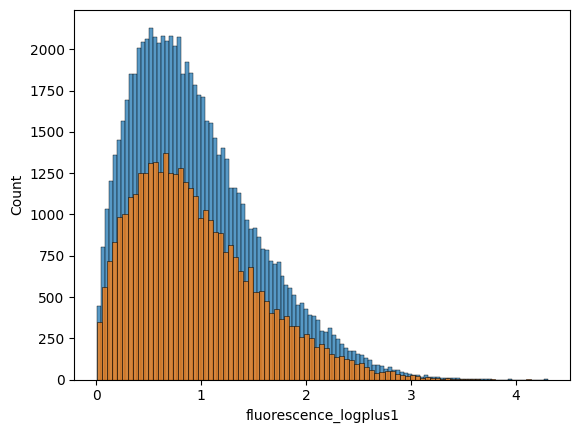

In [10]:
sns.histplot(y_train);sns.histplot(y_test)

In [11]:
#train_set = tf.data.Dataset.zip((seq_database, target_database))
train_set = tf.data.Dataset.zip((all_vec_seq, target_database))
test_dataset = tf.data.Dataset.zip((x_test_database, y_test_database))
real_train_set = train_set.batch(batch_size).shuffle(batch_size)
test_dataset = test_dataset.batch(batch_size)
#next(iter(train_set.batch(10)))

## Build Encoder of Transformer model

### Self attention

In [12]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True) # Shape = (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # calculate matmul_qk_v
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights, matmul_qk

#create multi-head attention layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        #Because for multi-head, head number * depth = multi-head
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #Set layers for q, k, v
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) # shape = (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights, matmul_qk= scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights, matmul_qk

### Fully connected layer and Encoder layer

In [13]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])
        
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #define layers
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):

        attn_output, attn_weight, matmul_qk = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weight, matmul_qk


### Position Encoding

In [14]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2*(i/2))/np.float32(d_model))
    return pos*angle_rate

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :]
                            ,d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [15]:
positional_encoding(1, 9)

<tf.Tensor: shape=(1, 1, 9), dtype=float32, numpy=array([[[0., 1., 0., 1., 0., 1., 0., 1., 0.]]], dtype=float32)>

### Encoder

In [16]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.3):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers #how many encoder layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.attention_weights = {}
        self.matmul_qks = {}
        
    def call(self, x, training, mask=None):
        #attention_weights = {}
        #encoding and position encoding
        seq_len = tf.shape(x)[1]
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block, matmul_qk = self.enc_layers[i](x, training, mask)
            self.attention_weights[f'attentions_{i+1}'] = block
            self.matmul_qks[f'matmul_qk_{i+1}'] = matmul_qk
            
        #attention_weights[f'decoder_layer{i+1}_block'] = block
        return x, block # (batch_size, input_seq_len, d_model)
    
    def get_attention(self):
        return self.attention_weights
    def get_matmul_qks(self):
        return self.matmul_qks

### Test of Encoder

In [17]:
sample_encoder = Encoder(num_layers=2, d_model=5, num_heads=1,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=30)
temp_input = vectorize_layer(seq_spaced)
#temp_input = tf.random.uniform((3, 24), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input[22:29], training=False, mask=None)
sample_encoder_output[0].shape

2023-11-16 00:24:28.179628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([7, 29, 5])

## Create model

In [18]:
def create_model(seq_length, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.3):
    input = tf.keras.Input(shape=(seq_length,))
    x , aws= Encoder(num_layers, d_model, num_heads, dff,
                input_vocab_size, maximum_position_encoding, rate=rate)(input)
    x = tf.keras.layers.Reshape((seq_length*d_model,))(x)
    x = tf.keras.layers.Dense(seq_length, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    output = tf.squeeze(x)
    
    return tf.keras.Model(inputs=input, outputs=output)
    

In [19]:
model = create_model(seq_length=seq_length, num_layers= num_layers, d_model=d_model, num_heads=num_heads,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=30)
p = vectorize_layer(seq_spaced.iloc[17])
model(p)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8515489>

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 encoder_1 (Encoder)         ((None, 29, 128),         397824    
                              (None, 8, None, None))             
                                                                 
 reshape (Reshape)           (None, 3712)              0         
                                                                 
 dense_24 (Dense)            (None, 29)                107677    
                                                                 
 dense_25 (Dense)            (None, 1)                 30        
                                                                 
 tf.compat.v1.squeeze (TFOp  None                      0         
 Lambda)                                                     

## Test our model to see if it can work and get the attention matrix

<Axes: >

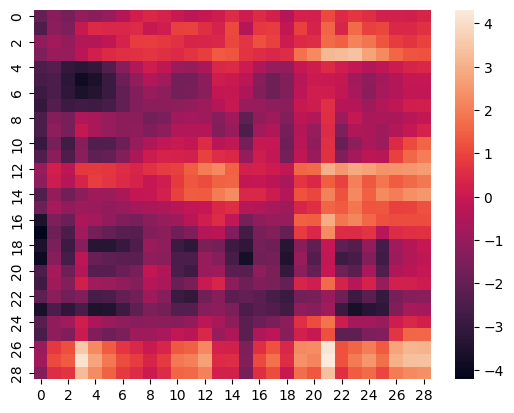

In [21]:
for i in real_train_set.take(1):
    q = model(i[0])
att = model.layers[1].get_attention()['attentions_1']
qk = model.layers[1].get_matmul_qks()['matmul_qk_1']
#forheat = tf.squeeze(att).numpy()
sns.heatmap(qk[(0,0)])

## Custom Schedule/ Accuracy/ Loss functions

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
#optimizer = tf.keras.optimizers.Adam()

#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
loss_object = loss=tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return tf.reduce_sum(loss_)


def accuracy_function(real, pred):
    accuracies = loss_object(real, pred)
    #accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.keras.losses.MeanAbsoluteError(real, pred)
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #accuracies = tf.math.logical_and(mask, accuracies)
    #accuracies = tf.cast(accuracies, dtype=tf.float32)
    #mask = tf.cast(mask, dtype=tf.float32)
    #return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    return tf.reduce_sum(accuracies)

train_metric = tfa.metrics.r_square.RSquare()
test_metric = tfa.metrics.r_square.RSquare()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [23]:
 
checkpoint_path = "./checkpoints_64_21_pos_周/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Customized Train/Test steps

If you face some type mismatch, please use pip install typeguard==2.13.3.
typeguard 3.0.0 version was released recently that's the reason why it's not working.

Source: https://stackoverflow.com/questions/75759597/typeerror-isinstance-arg-2-must-be-a-type-or-tuple-of-types-in-tensorflow-add

In [24]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

#train_step_signature = [
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#    tf.TensorSpec(shape=(None), dtype=tf.int64),
#]


#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    #inp = inp
    target = tar

    with tf.GradientTape() as tape:
        predictions = model(inp, training = True)
        loss = loss_function(target, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)

    train_metric.update_state(target, predictions)
    #result = metric.result()
    #train_accuracy(result)
    #train_accuracy(accuracy_function(target, predictions))
    
def test_step(model, inp, tar):
    #inp = inp
    target = tar
    predictions = model(inp)
    testloss = loss_function(tar, predictions)
    test_loss(testloss)
    test_metric.update_state(target, predictions)

    #result = metric.result()
    #test_accuracy(result)

    #train_accuracy(accuracy_function(target, predictions))

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+ '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+  '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## Train loop

In [25]:
import time
EPOCHS= 500

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()


  for (batch, (inp, tar)) in enumerate(real_train_set):
    train_step(inp, tar)
    if batch % 300 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_metric.result(), step=epoch)

  for (batch, (inp, tar)) in enumerate(test_dataset):
    test_step(model, inp, tar)

  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy_test', test_metric.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Test Loss: {}, Test R^2: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         test_loss.result(),
                         test_metric.result()
                         ))
  #Print out information
 

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  # if early_stopping.monitor_op(test_loss.result()):
  #   print("Validation loss is not decreasing. Stopping training.")
  #   break

2023-11-15 23:20:33.397959: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56f7e240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-15 23:20:33.397975: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-11-15 23:20:33.400945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-15 23:20:33.473287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-15 23:20:33.540179: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 Batch 0 Loss 1.4726 Accuracy -6.8078
Epoch 1, Loss: 0.7832799553871155, Test Loss: 0.5115034580230713, Test R^2: -0.05951571464538574
Epoch 2 Batch 0 Loss 0.5046 Accuracy -1.8451
Epoch 2, Loss: 0.4966903328895569, Test Loss: 0.4979340434074402, Test R^2: -0.017013907432556152
Epoch 3 Batch 0 Loss 0.4573 Accuracy -0.9898
Epoch 3, Loss: 0.4756537675857544, Test Loss: 0.49186646938323975, Test R^2: 0.010154366493225098
Epoch 4 Batch 0 Loss 0.4653 Accuracy -0.6748
Epoch 4, Loss: 0.44903141260147095, Test Loss: 0.4769477844238281, Test R^2: 0.061509549617767334
Epoch 5 Batch 0 Loss 0.3740 Accuracy -0.4901
Epoch 5, Loss: 0.4143874943256378, Test Loss: 0.4695534408092499, Test R^2: 0.08800351619720459
Saving checkpoint for epoch 5 at ./checkpoints_64_21_pos_周/model_2_8_128_512/ckpt-1
Epoch 5 Loss 0.4144 Accuracy -0.3534
Time taken for 1 epoch: 4.81 secs

Epoch 6 Batch 0 Loss 0.3873 Accuracy -0.3524
Epoch 6, Loss: 0.40214237570762634, Test Loss: 0.46625998616218567, Test R^2: 0.0932176

## Visualize attentions

In [26]:
df["seq_spaced"] = seq_spaced
def visualize_attention(heads, labels, attention):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1,heads)
    plt.set_cmap('bwr')
    for i in range(heads):
        ax = axs[i]
        cax = ax.matshow(attention[i])
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_xticklabels(labels, rotation=90)
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_yticklabels(labels)
        print(f"head{i}: {tf.reduce_max(attention[i])}")
        print(f"head{i}: {tf.reduce_min(attention[i])}")
    cbar = fig.colorbar(cax)

def plot_attention_head(sequence, attention, heads):
    # The plot is of the attention when a token was generated.
    # # The model didn't generate `<START>` in the output. Skip it.
    labels = [label for label in sequence.to_numpy()[0]]
    #translated_tokens = translated_tokens[1:]
    #ax = plt.gca()
    visualize_attention(heads = heads, labels=labels, attention=attention)
    
   

## Test individual sequence

In [27]:
# seq = 'AAAACAGGCGCCTCGAGTCCTTGTATAAT'
# sequence_demo = df[df.promoter == seq].seq_spaced
# rka_for_show = df[df.promoter == seq].fluorescence_logplus1
# p = vectorize_layer(sequence_demo)
# result = model(p)
# att = model.layers[1].get_attention()['attentions_1'][0]
# matmul_qk_s = model.layers[1].get_matmul_qks()['matmul_qk_1'][0]
# R = sequence_demo.str.split(" ")

# plot_attention_head(R,matmul_qk_s, num_heads)
# print('sequence: ', sequence_demo.to_numpy())
# print(f'predicted fluorescence: {result.numpy()}, real fluorescence {rka_for_show}')

## Verify the predicted result

In [24]:

result = model.predict(x_test_database.batch(1024))
result.shape

37/37 [==============================] - 1s 10ms/step


(37276,)

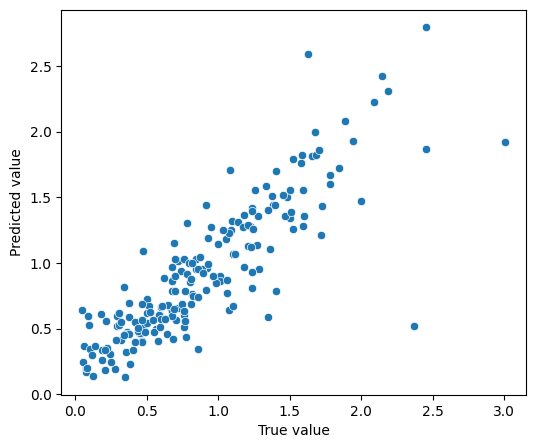

In [25]:
y_test = y_test.reset_index(drop=True)
# 设置随机种子以保证结果的可重复性
np.random.seed(0)

# 生成随机索引
random_indices = np.random.choice(len(y_test), size=200, replace=False)

# 使用随机索引从y_test和result中获取值
random_y_test = y_test[random_indices]
random_result = result[random_indices]

plt.rcParams["figure.figsize"] = (6,5)
sns.scatterplot(x=random_y_test, y=random_result)

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.savefig("./checkpoints_64_21_pos_周/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/True_Predicted.png')


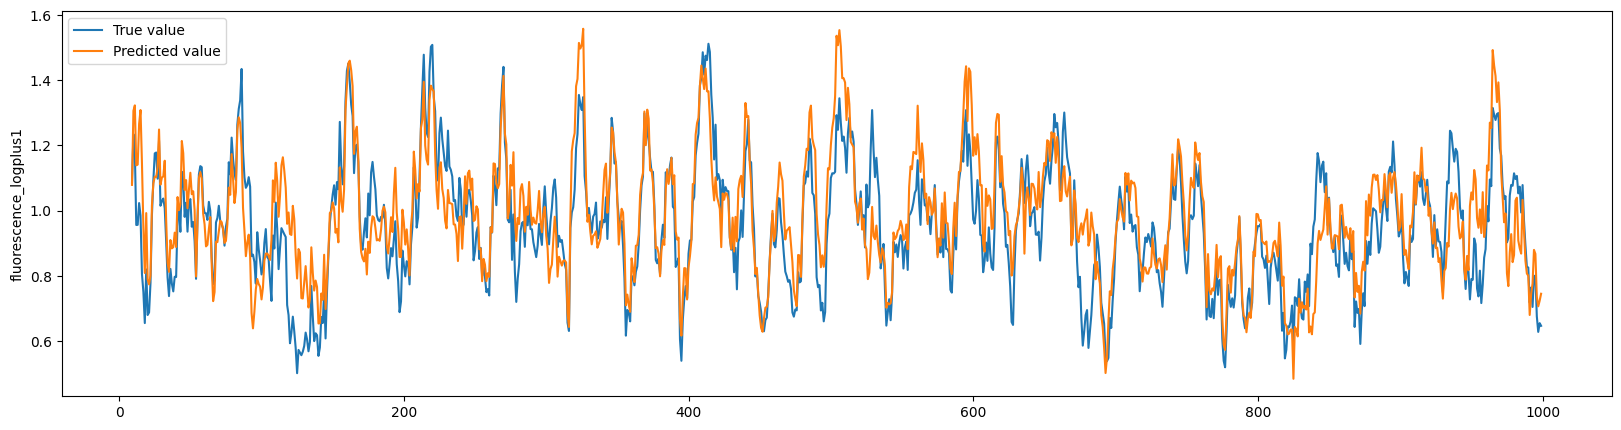

In [26]:
# 绘制前200个数据的数值大小对比图
result.shape, y_test.shape
plt.rcParams["figure.figsize"] = (20,5)
sns.lineplot(data=pd.Series(y_test)[:1000].rolling(10).mean() ,label="True value")
sns.lineplot(data=pd.Series(result)[:1000].rolling(10).mean(), label="Predicted value")
plt.savefig("./checkpoints_64_21_pos_周/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/True_Predicted_line.png')

In [27]:
# Calculate R^2
from sklearn.metrics import r2_score
r2_score(y_test, result)

0.7132263155143164

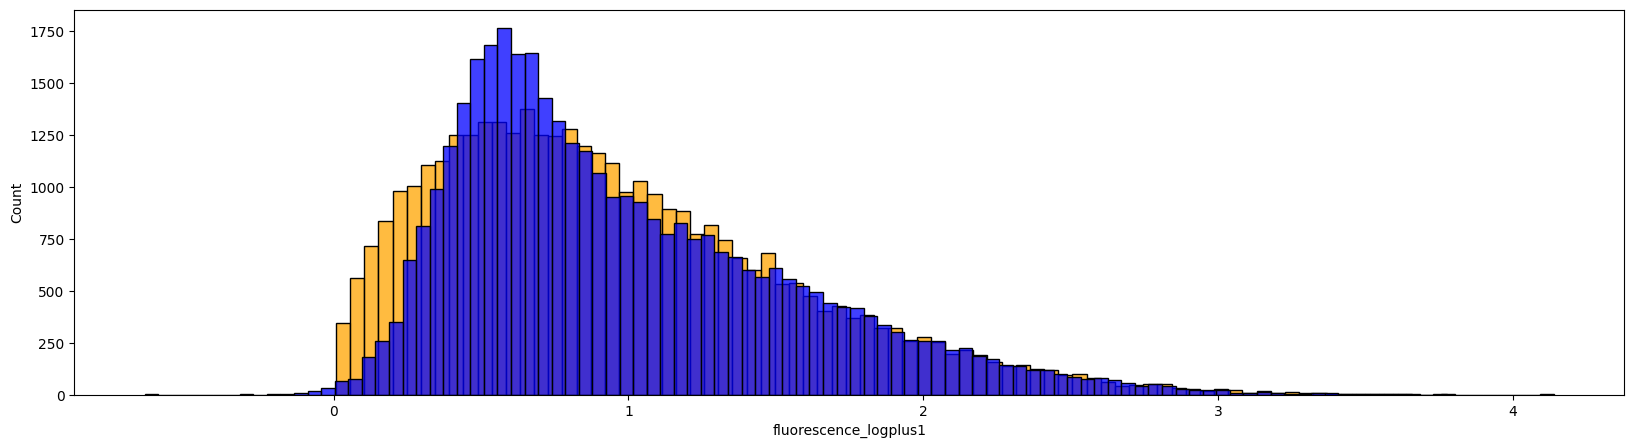

In [28]:
sns.histplot(y_test, color = "orange")
sns.histplot(result, color = "blue")
# 将输出图保存在本地
plt.savefig("./checkpoints_64_21_pos_周/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/histplot.png')



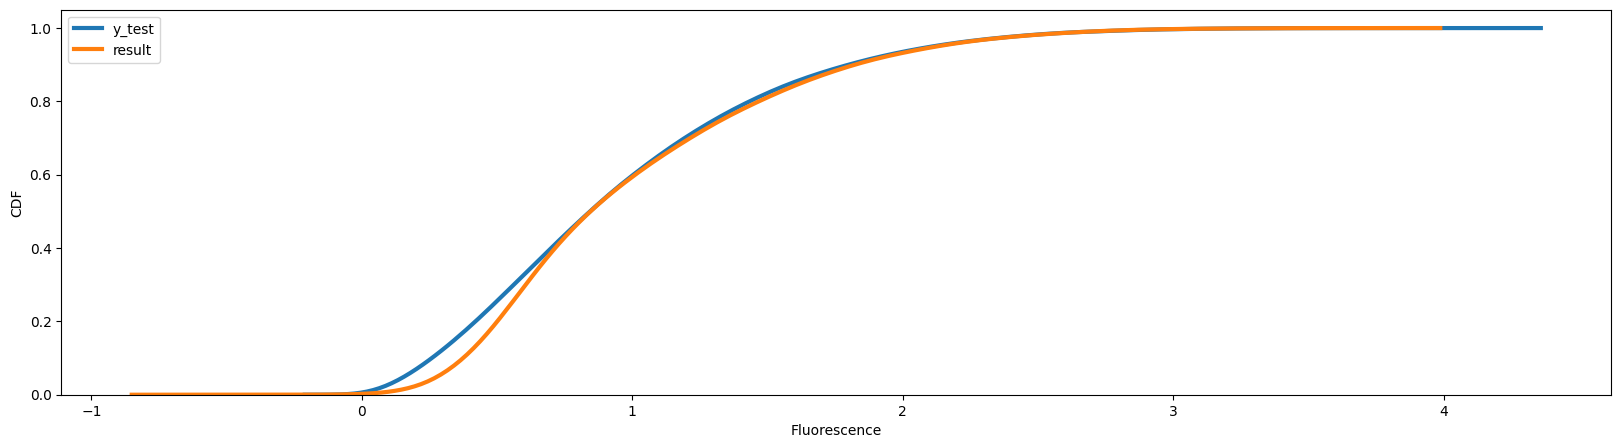

<Figure size 2000x500 with 0 Axes>

In [30]:
import seaborn as sns

# 设置图像大小
plt.figure(figsize=(20, 5))

# 使用seaborn的kdeplot函数绘制CDF
sns.kdeplot(y_test, cumulative=True, label='y_test', linewidth=3)
sns.kdeplot(result, cumulative=True, label='result', linewidth=3)

# 设置图像的标签
plt.xlabel('Fluorescence')
plt.ylabel('CDF')
plt.legend()

# 显示图像
plt.show()

# 保存图像
plt.savefig("./checkpoints_64_21_pos_周/"+"model" +'_' + str(num_layers) + '_'+ str(num_heads) + '_' + str(d_model) + '_' + str(dff)+'/CDF.png')
